# Mecanismos de Votación


> __Alcances de esta sesión:__

> * Implementar mecanismos de votación en modelos heterogéneos con `sklearn`.
> * Conocer las virtudes representacionales, estadísticas y computacionales de los mecanismos de votación.
> * Conocer los mecanismos de votación para vectores objetivos contínuos y discretos.
> * Implementar distintos esquemas de ponderación en los modelos heterogéneos.

## Motivación

> __Caveat:__ A lo largo de la lectura implementaremos los términos _mecanismo de votación_, _ensamble heterogéneo_ y _comité_ de manera intercambiable.

Hasta el momento entendemos que los ensambles buscan generar un mejor modelo particular que represente la resolución un fenómeno. Los mecanismos de votación - o métodos combinatorios de algoritmos (Diettirch, 2000 en Zhou, 2012), buscan explotar la variedad de modelos entrenados en funcióna tres razones fundamentales:

- __Poder Representacional__: Resulta que en algunas tareas, el modelo no puede capturar el comportamiento empírico del fenómeno mediante una función singular. Mediante la combinación de distintos modelos, es posible expandir el espacio de las funciones representativas, acercando el comportamiento del ensamble.

- __Estadística__: Resulta que a veces el comportamiento empírico del fenómeno es muy amplio como para explorar con una cantidad limitada de datos, así como múltiples modelos pueden arrojar resultados similares en los conjuntos de entrenamiento. Mediante un ensamble podemos reducir el espacio del comportamiento empírico del fenómeno.

- __Computacional__: Algunos algoritmos puede sufrir de ineficiencia en su proceso de optimización de la función de pérdida en un punto específico. Mediante los métodos de combinación podemos explorar distintos puntos de partida en nuestra función de pérdida, mapeando la mejor solución.

Tenemos conocimiento sobre ensambles paralelos como Bagging o Random Forests, y ensambles secuenciales como Adaptive Boosting y Gradient Boosting. Uno de los puntos en común de estos ensambles es el hecho que iteran sobre el mismo tipo de modelo, lo cual puede generar problemas dada la tendencia a correlacionar predicciones entre sí. Resulta que una de las principales ventajas de los mecanismos de votación es utilizar de forma explícita la naturaleza heterogénea de los modelos.

De hecho, los ensambles funcionan de mejor manera cuando los modelos candidatos son independientes entre sí. Esto aumenta la diversidad de los errores a generar, lo que se compensa mediante las clasificaciones de otros modelos. De esta manera, es posible aumentar la exactitud general del comité.

Parte de la reciente popularidad de los mecanismos de votación se debe al éxito en la competencia de Netflix (Steinki y Mohammad, 2015). En el 2009 Netflix abrió un concurso donde cualquier participante que pueda desarrollar un algoritmo de filtro colaborativo para recomendaciones. De todos los modelos existentes, un mecanismo de votación fue el que más redujó el error cuadrático promedio en comparación al benchmark previo de .8563.


## Rudimentos

A grandes rasgos, los mecanismos de votación en ensambles diferencia en una primera etapa si el vector objetivo es contínuo o discreto. Posteriormente, se diferencia por el grado de ponderación a cada modelo dentro del ensamble.

### Métodos de combinación para vectores objetivos contínuos

Si tenemos un modelo $t \in \mathcal{T}$, donde $\mathcal{T}$ es un conjunto de modelos $t$ entrega una función candidata $h_{i}(\mathbf{x}) \in \mathbb{R}$. El objetivo es combinar cada función candidata en el ensamble $\mathcal{T}$ para generar una predicción final. Existen dos grandes variantes

#### Promedio simple

Como lo señala su nombre, el ensamble promedia cada una de las predicciones realizadas por el modelo.

$$
\mathcal{H}(\mathbf{x}) = \frac{1}{\mathcal{T}}\sum_{t=1}^{\mathcal{T}}h_{t}(\mathbf{x})
$$

Supongamos que deseamos aprender una función $f(\mathbf{x})$, donde $\mathbf{x}$ sigue una distribución arbitraria $p(\mathbf{x})$. Resulta que las funciones candidatas $h$ se pueden escribir de la siguiente manera:

$$
h_{t}(\mathbf{x}) = f(\mathbf{x}) + \varepsilon_{t}(\mathbf{x}), \quad \forall t \in \mathcal{T}
$$

Este hecho permite desagregar la variabilidad de cada función candidata entre una "valor verdadero" y un término de error específico al ensamble. Mediante esta desagregación del error se puede analizar el error promedio del ensamble y observar si es menor a la esperanza del error (para más detalles sobre este supuesto, referirse a Zhou, 2012, pp. 69).

Dada la simplicidad y efectividad, es uno de los métodos más utilizados. Uno de los problemas es que se realiza el supuesto que los errores de cada función candidata no están correlacionados entre sí, situación extremadamente rara cuando implementamos ensambles.

#### Promedio ponderado

Una manera de calibrar las predicciones realizadas por un ensamble heterogéneo es mediante la inclusión de ponderadores de la siguiente manera:
$$
\mathcal{H}(\mathbf{x}) = \frac{1}{\mathcal{T}}\sum_{t=1}^{\mathcal{T}}w_{t}h_{t}(\mathbf{x})
$$

donde $w_{i}$ es el ponderador de la función candidata de un modelo candidato $h_{t}$. Todo ponderador es no negativo y la suma de éstos da 1.

### Métodos de combinación para vectores objetivos discretos

Si tenemos un modelo $t \in \mathcal{T}$, donde $\mathcal{T}$ es un conjunto de modelos, $t$ entrega una función candidata $h_{i}(\mathbf{x})$ que busca predecir una clase específica $c$ dentro de un conjunto finito de clases $C$. El objetivo es combinar cada función candidata en el ensamble $\mathcal{T}$ para generar una predicción final.

Se asume que para una instancia específica a predecir con una función candidata $h$, ésta entrega un vector $\{h^{1}_{t}(\mathbf{x}), \cdots,h^{c}_{t}(\mathbf{x})\}^{\mathsf{T}}$. Cada uno de estos registros puede tomar distintos valores condicional a cada clasificador individual:

- Clase: $h^{c}_{t}(\mathbf{x}) \in \{0, 1\}$ que toma el valor de 1 si $h_{t}$ predice $c$ como la clase, 0 de lo contrario.
- Etiqueta: $h^{c}_{t}(\mathbf{x}) \in [0, 1] \rightarrow \textsf{Pr}(c \vert \mathbf{x})$

Para los casos como Support Vector Machines, donde los clasificadores producen márgenes no normalizados, se pueden convertir sus outputs en probabilidades mediante métodos de calibración como Platt Scaling o regresión isotónica.

#### Voto por Mayoría (Majority Voting)

Cada clasificador vota por una clase específica, y el output final a nivel de ensamble es aquél que reciba más del 50% de los votos. Si esta condición no se cumple, se puede aplicar una opción de rechazo para el clasificador.

$$
\mathcal{H}(\mathbf{x}) = 
\begin{cases}
C & \textsf{si} \sum_{t=1}^{T}h_{t}^{j}(\mathbf{x}) > \frac{1}{2}\sum_{k=1}^{l}\sum_{t=1}^{T}h_{t}^{k}(\mathbf{x}) \\
\textsf{rechazo} & \textsf{de lo contrario} \\
\end{cases}
$$

Si hay un total de $\mathcal{T}$ clasificadores binarios, el ensamble será correcto si por lo menos $\frac{\mathcal{T}}{2} + 1$ clasificadores eligen la misma clase. La probabilidad del ensamble de tener una decisión correcta se puede inferir a partir de la distribución binomial de cada clasificador

$$
\textsf{Pr}_{mv}  = \sum_{k = [t/2 + 1]}^{\mathcal{T}} \binom{\mathcal{T}}{k} \pi^{k}(1-\pi)^{\mathcal{T}-k}
$$

La figura presentada a continuación visualiza el proceso de clasificación por mayoría. En este ejemplo tenemos un conjunto de datos que será ingresado en una serie de clasificadores, que asumiremos que son débiles. En la primera etapa generamos las predicciones de clase a nivel de modelos, y posteriormente contamos la cantidad de ocurrencias de cada clase $c \in C$.
![](img/voting_classifier.svg)


#### Voto por mayoría relativa (Plurarity Voting)

Siguiendo el ejemplo, el ensamble sugiere que la observación a predicir debe ser un 0 dado que 3 de 4 clasificadores débiles predicen 0. En este caso tanto la votación por mayoría (50% + 1) o mayoría relativa arrojan el mismo resultado.

$$
\mathcal{H}(\mathbf{x}) = \underset{c}{\textsf{argmax}}\sum_{t=1}^{\mathcal{T}}h_{t}^{c}(\mathbf{x})
$$



#### Promedio Ponderado

Supongamos que al realizar la inspección de cada modelo individual dentro del comité observamos que el desempeño individual del clasificador generativo `BernoulliNB` es subtancialmente superior al resto. Una manera de corregir esto es mediante la ponderación a nivel de etiqueta. Para ello, actualizamos el modelo a incluír tantos ponderadores como modelos existan, siempre teniendo en mente que $\sum_{i=1}^{N} w_{i} \equiv 1$

![](img/weighted_voting_classifier.svg)

En el contexto de un ensamble ponderado, la predicción sigue una mayoría relativa. El ponderador específico $w_{i}$ opera al multiplar la predicción por la relevancia del clasificador.

$$
\mathcal{H}(\mathbf{x}) = \underset{c}{\textsf{argmax}}\sum_{t=1}^{\mathcal{T}}w_{i}h_{t}^{c}(\mathbf{x})
$$

#### Soft Voting

Para clasificadores que producen un reporte en probabilidad, generalmente se implementa 
el siguiente criterio de clasificación. 

Se asume que para una instancia específica a predecir con una función candidata $h$, ésta entrega un vector $\{h^{1}_{t}(\mathbf{x}), \cdots,h^{c}_{t}(\mathbf{x})\}^{\mathsf{T}}$ para una instancia específica $\mathbf{x}$ donde $h^{c}_{t}(\mathbf{x}) \in [0, 1]$ se puede entender como un estimado de la probabilidad _a posteriori_ $\textsf{Pr}(c \vert \mathbf{x})$.

Si todos los clasificadores se asumen con el mismo peso, el método genera el promedio de cada modelo y el output final responde a

$$
\mathcal{H}^{c}(\boldsymbol x) = \frac{1}{\mathcal{T}}\sum_{t=1}^{\mathcal{T}}h_{t}^{c}(\boldsymbol x)
$$

Si el ensamble heterogéneo presenta un esquema de ponderación específico, el método de agregación puede seguir una de las tres variantes:

- __Ponderador específico a nivel de clasificador__:

$$
\mathcal{H}^{c}(\boldsymbol x) = \sum_{t=1}^{\mathcal{T}}w_{i}h_{i}^{c}(\boldsymbol x)
$$

- __Ponderador específico a nivel de clasificador y clase__:

$$
\mathcal{H}^{c}(\boldsymbol x) = \sum_{t=1}^{\mathcal{T}}w_{i}^{c}h_{i}^{c}(\boldsymbol x)
$$
- __Ponderador específico a nivel de observación, clasificador y clase__:


$$
\mathcal{H}^{c}(\boldsymbol x) = \sum_{i=1}^{\mathcal{T}}\sum_{j=1}^{m}w_{ij}^{c}h_{i}^{c}(\boldsymbol x)
$$

Zhou (2012) sugiere que el mecanismo soft voting funciona mejor con ensambles homogéneos, dado que las probabilidades de clase estimadas por modelos distintos puede que no sean directamente comparables. 


## Ejemplo: Estimando el tiempo de ejecución de tareas en un HPC

> __Caveat:__ Por motivos expositivos, el objetivo del ejercicio es demostrar bajo qué situaciones un ensamble puede empeorar la capacidad de generalización en los datos. Deben tener en cuenta que la experiencia práctica es reducir la pérdida y mejorar la predicción.

Para ilustrar el funcionamiento del mecanismo de votación, analizaremos el tiempo de ejecución de trabajos en un ambiente HPC (High Performance Computing). El objetivo es generar un modelo predictivo que prediga correctamente aquellos trabajos que tendrán un tiempo de ejecución substancialmente alto. De los 4331 registros existentes, se capturaron siete atributos:

- `Protocol`: El tipo de la computación implementada en $x_{i}$ registro.
- `Compounds`: La cantidad de puntos de datos para cada trabajo.
- `InputFields`: La cantidad de características a estimar en cada trabajo.
- `Iterations`: El número máximo de iteraciones a ejecutar por trabajo.
- `NumPending`: La cantidad de trabajos en lista a ser ejecutados.
- `Hour`: Hora decimal para la hora de ejecución.
- `Day`: Día de la ejecución.
- `Class`: El vector objetivo que mide el tiempo de ejecución. Ésta contiene cuatro categorías: Very Fast (VF), Fast (F), Medium (M), Low (L).

In [13]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lec10_graphs as afx
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

rep_seed = 11238

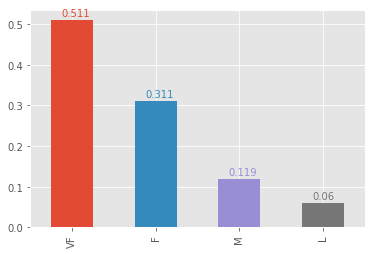

In [2]:
df = pd.read_csv('hpcjobschedule.csv').drop(columns='Unnamed: 0')
   
def annotated_barplot(var):
    tmp_values = var.value_counts('%')
    tmp_ax = tmp_values.plot(kind='bar')
    for index, p in enumerate(tmp_ax.patches):
        tmp_ax.annotate(tmp_values[index].round(3),
                       xy=(p.get_x() + .125,
                          p.get_height() + 0.01),
                       color=p.get_facecolor())
        
annotated_barplot(df['Class'])

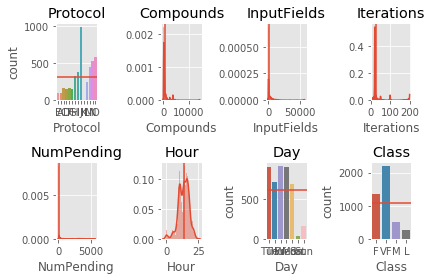

In [3]:
# definimos el dimensionado de nuestra grilla
rows= 2; cols = len(df.columns) // rows
# definimos el tamaño de la figura
afx.plot_describe_variables(df, rows=rows, cols=cols)

## Implementación de `sklearn.ensemble.VotingClassifier`

Para entender la implementación de un mecanismo de votación, generaremos la siguiente estrategia analítica:

1. Partimos por incorporar los módulos clásicos de evaluación para tareas de clasificación, así como el módulo de separación de muestras.
- Posteriormente incorporaremos una serie de modelos candidatos que participarán en el mecanismo de votación. Éstos son:
    - Naïve Bayes. `sklearn.naive_bayes.BernoulliNB`
    - Análisis Discrminante Lineal. `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`
    - Regresión logística. `sklearn.linear_model.LogisticRegression`
    - Árboles de clasificación. `sklearn.tree.DecisionTreeClassifier`
    - Clasificador con soporte vectorial con un kernel `rbf`. `sklearn.svm.SVC`
    - Kmeans con dos clusters. `sklearn.cluster.KMeans`
    - Modelo de Mezcla Gaussiana con dos clusters. `sklearn.mixture.GaussianMixture`
- Finalmente incorporaremos el módulo `sklearn.ensemble.VotingClassifier`.

In [4]:
# Módulos de preprocesamiento
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Módulos de modelos
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

Nuestro objetivo es generar un sistema predictivo para aquellos casos donde la demora es substancialmente menor. Para ello recodificaremos y aislaremos la variable que identifique aquellas observaciones clasificadas como "Very Fast". De manera adicional, implementaremos los pasos de división entre muestras de evaluación, holdout, entrenamiento y validación. 

Un aspecto a considerar es que en este caso el vector objetivo presenta clases desbalanceadas, por lo que el desempeño del modelo debería ser similar para predecir ambas clases.

In [5]:
# recodificamos nuestro vector objetivo
df['very_fast'] = np.where(df['Class'] == 'VF', 1, 0)
# generamos un conjunto de variables binarias para Day y Protocol.
df = pd.concat([df,pd.get_dummies(df['Day'], drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['Protocol'], drop_first=True)], axis=1)
# Eliminamos las variables originales
df = df.drop(columns=['Protocol', 'Class', 'Day'])

Retomando el gráfico descriptivo de los datos, un problema existente con los atributos `Compounds`, `InputFields`, `Iterations`, `NumPending` era la concentración en valores bajos. Para corregir por este sesgo tomaremos el logaritmo de cada variable y le sumaremos 0.01 para evitar el problema $\textsf{log}(0)$. 

In [6]:
log_vars = ['Compounds', 'InputFields', 'Iterations', 'NumPending']
for i in log_vars:
    df[i] = df[i].apply(lambda x: np.log(x +0.001))

Si revisamos la corrección de las variables, observamos que los atributos `Compounds` e `InputFields` cambiaron drásticamente el comportamiento, asemejándose a una distribución más normal. Lamentablemente eso no se replica para 

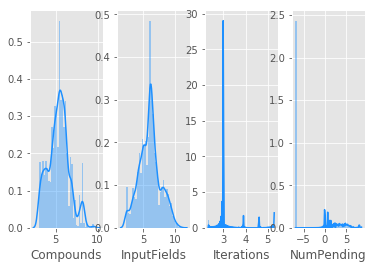

In [7]:
for index, value in enumerate(log_vars):
    plt.subplot(1, 4, index + 1)
    sns.distplot(df[value], color='dodgerblue')

In [8]:
# preservamos en una nueva variable nuestro vector objetivo
y = df.pop('very_fast')
# Generamos la separación entre muestra de evaluación y holdout
X_eval, X_holdout, y_eval, y_holdout = train_test_split(df, y, test_size=.33, random_state=rep_seed)
# Separamos la muestra de entrenamiento entre entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval, test_size=.33, random_state=rep_seed)
print(f'Registros holdout: {X_holdout.shape[0]} / Atributos holdout: {X_holdout.shape[1]}')
print(f'Registros training: {X_train.shape[0]} / Atributos training: {X_train.shape[1]}')
print(f'Registros testing: {X_test.shape[0]} / Atributos holdout: {X_test.shape[1]}')

Registros holdout: 1430 / Atributos holdout: 24
Registros training: 1943 / Atributos training: 24
Registros testing: 958 / Atributos holdout: 24


### Montando el ensamble de clasificadores heterogéneos

Para implementar la lista de estimadores, `sklearn.ensemble.VotingClassifier` necesita de una lista de tuplas, donde cada tupla debe seguir la siguiente nomenclatura: `('Etiqueta del Estimador', MóduloDelModelo)`. Para este ejemplo, definiremos la siguiente lista:

In [9]:
# definimos el comité de clasificadores en una lista de tuplas
estimators = [('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
              ('Logistic Regression', LogisticRegression(random_state=rep_seed)),
              ('Decision Tree Classifier', DecisionTreeClassifier(random_state=rep_seed)),
              ('Support Vector Classifier', SVC(kernel='linear', random_state=rep_seed)),
              # para el caso de kmeans y GMM es necesario definir la cantidad de clusters a inferir
              ('Kmeans', KMeans(n_clusters=2, random_state=rep_seed)),
              ('Gaussian Mixture Model', GaussianMixture(n_components=2,random_state= rep_seed))]

In [10]:
estimators[4:]

[('Kmeans',
  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
      n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
      random_state=11238, tol=0.0001, verbose=0)),
 ('Gaussian Mixture Model',
  GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
          means_init=None, n_components=2, n_init=1, precisions_init=None,
          random_state=11238, reg_covar=1e-06, tol=0.001, verbose=0,
          verbose_interval=10, warm_start=False, weights_init=None))]

### Comportamiento individual de los estimadores

Antes de generar el ensamble, una práctica útil es observar el desempeño de cada clasificador dentro del ensamble. Para ello implementaremos la función `afx.plot_classification_report` que visualiza los resultados de la función `sklearn.metrics.classification_report`. Para más detalles sobre la función, pueden referirse al archivo auxiliar.

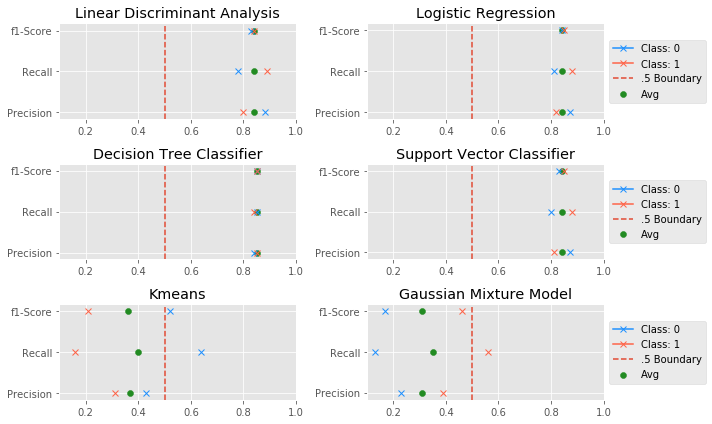

In [32]:
for index, value in enumerate(estimators):
    plt.subplot(3, 2,  index + 1)
    plt.title(value[0])
    class_pred = value[1].fit(X_train, y_train).predict(X_test)
    afx.plot_classification_report(y_test, class_pred)
    plt.axvline(.5, label='.5 Boundary', linestyle='--')
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

Cabe destacar que 4 de 6 clasificadores que forman parte del comité presentan un desempeño más que aceptable. En promedio, tanto Linear Discriminant Analysis, Logistic Regression, Decision Tree Classifier y Support Vector Machine presentan métricas sobre el 80% en Precision, Recall y F1. En el otro extremo encontramos los modelos KMeans y Gaussian Mixture Model, que presentan un desempeño general substancialmente peor que un clasificador aleatorio. Cabe destacar que mantendremos estos clasificadores en el comité por motivos pedagógicos. En aplicaciones serias, estos modelos se eliminarían del comité.

De los primeros cuatro modelos, el comportamiento de Decision Tree Classifer es mucho más estable a nivel de clases específicas en comparación a los otros tres modelos. En específico, se observa que tanto para Linear Discriminant Analysis, Logistic Regression y Support Vector Classifier tienen un mejor recall en la clase 1. Esto significa que logran capturar más registros, mientras que tienden a clasificar con una mayor precisión las clases 0.

Resulta que cada modelo responde a distintas representaciones de los datos. De esta manera, al implementar el algoritmo de votación `sklearn.ensemble.VotingClassifier` promediaremos virtudes y defectos de cada clasificador individual. Por el momento, generemos una implementación vanilla del modelo, sin modificar hiperparámetros. 

In [11]:
# VotingClassifier requiere de la lista de tuplas que definimos arriba
voting_classifier = VotingClassifier(estimators).fit(X_train, y_train)

Si visualizamos el comportamiento del ensamble heterogéneo, éste tiende a corregir el comportamiento de los indicadores, asimilándolos entre sí. Observamos que los puntajes f1 para cada clase converge con el promedio. De igual manera, el recall de la clase 0 mejora en comparación al desempeño de los modelos con desempeños superiores pero que tenían un recall bajo de la clase 0.

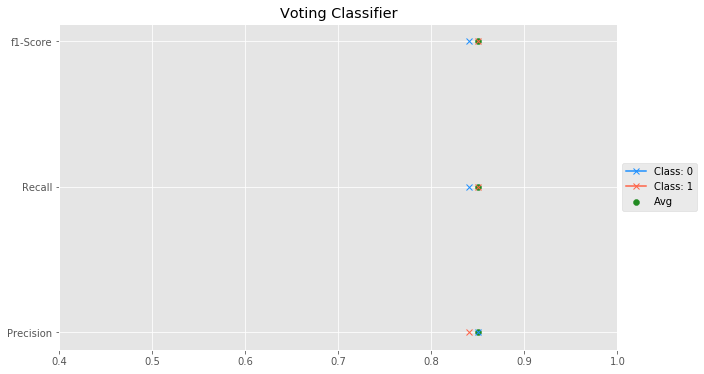

In [27]:
afx.plot_classification_report(y_test,voting_classifier.fit(X_train,y_train).predict(X_test))
plt.xlim((0.4, 1.0))
plt.title('Voting Classifier');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Hasta ahora hemos trabajado con la versión vanilla del clasificador. La siguiente sección profundiza sobre el esquema de ponderación en el ensamble.


### Estrategias de ponderación

El siguiente ejercicio busca ejemplificar el comportamiento del mecanismo de votación en distintos esquemas de ponderación. Someteremos nuestro clasificador previamente entrenado a cinco estrategias. Para ajustar los pesos nos valemos de información sobre el comportamiento individual de cada clasificador. Sabemos que los modelos Kmeans y Gaussian Mixture presentaban un desempeño substancialmente inferior al resto de los clasificadores. 

La primera estrategia a implementar es idéntica a la implementación vanilla de `sklearn.ensemble.VotingClassifier`. En la segunda y la tercera estrategias decreceremos los pesos de LDA, LogisticRegression, DecisionTreeClassifier y SVC en una misma tasa y aumentaremos el peso de KMeans de .20 a .30 y mantendremos el peso de GMM en .30. La cuarta y quinta iteración busca disminuír el efecto de los clasificadores con un desempeño inferior al clasificador aleatorio. Específicamente en el quinto esquema, suprimimos completamente la injerencia de éstos. 

Por motivos de brevedad, la evaluación de las estrategias de ponderación se desarrollaron en la función `afx.weighting_schedule` que se encuentra disponible en el archivo auxiliar. La función solicita ingresar el clasificador, las muestras de entrenamiento y validación, así como el esquema de ponderación definido en un diccionario.

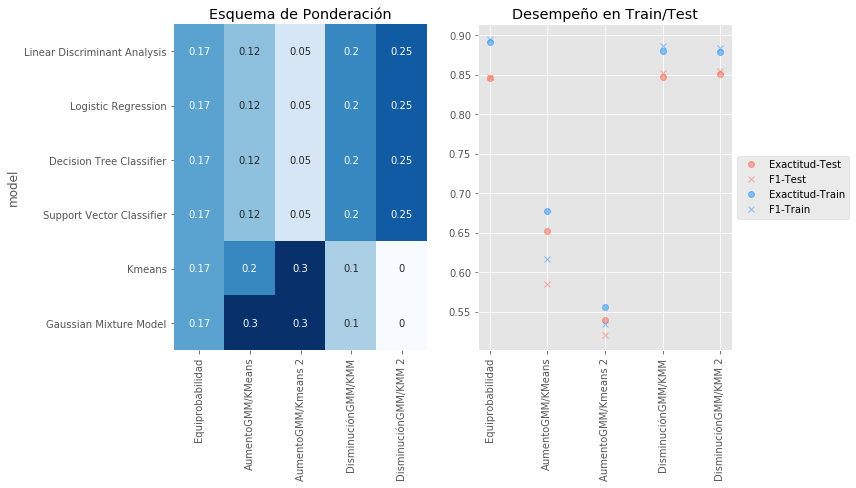

In [14]:
# definimos un diccionario con el esquema de ponderación a aplicar
weights_hyperparams = {
                       'Equiprobabilidad': [.166, .166, .166, .166, .166, .166],
                       'AumentoGMM/KMeans': [.125, .125, .125, .125, .20, .30],
                       'AumentoGMM/Kmeans 2': [.05, .05, .05, .05, .30, .30], 
                       'DisminuciónGMM/KMM': [.20, .20, .20, .20, .10, .10],
                       'DisminuciónGMM/KMM 2': [.25, .25, .25, .25, .0, .0]
                      }

# implementamos la evaluación del modelo
afx.weighting_schedule(voting_classifier, X_train, X_test, y_train, y_test, weights_hyperparams)

La figura izquierda visualiza el esquema de cada ponderación, y la figura de la derecha visualiza el desempeño de cada esquema en las muestras de entrenamiento y validación (medidas como Exactitud y punjate F1). El primer elemento a destacar es que en una estrategia equiprobable, el mecanismo de ensamble ofrece un buen desempeño, llegando a un 85% y 90% en ambas métricas para las muestras de validación y entrenamiento respectivamente.

Como era de esperar, el efecto de aumentar la relevancia de clasificadores con un desempeño inferior al clasificador aleatorio disminuye la exactitud general del ensamble heterogéneo, llegando a un mínimo de 55%. Este escenario ocurre cuando entre KMeans y GMM acaparan el 60% de los ponderadores. Cuando suprimimos el efecto de éstos, el desempeño en la muestra de validación es marginalmente superior al escenario equiprobable.

También podemos visualizar la votación de cada clasificador en la votación. Un primer aspecto a considerar es la alta importancia de los modelos KMeans y GMM en la identificación de las clases 0. En específico, la relevancia de GMM es la más importante. Cabe destacar que en esta estrategia estamos evaluando mayoría simple (opción que se define con `voting='hard'` en `VotingClassifier`), por lo que todas las predicciones con 3 o menos votos asignan las observaciones como 0, mientras que cuando superan el 50%, las observaciones se clasifican como 1. 

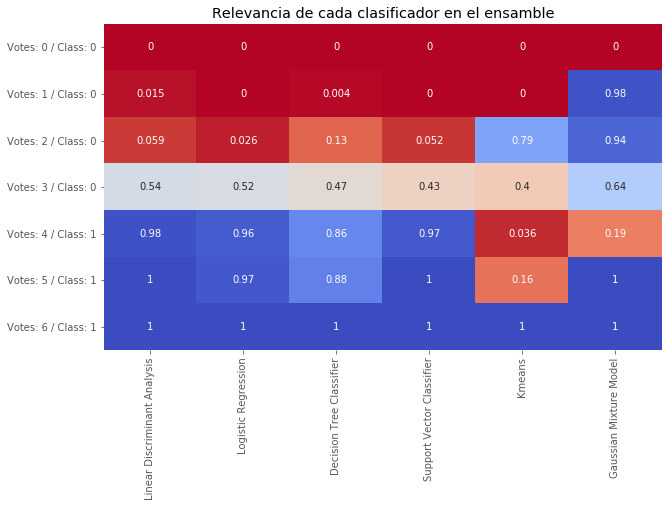

In [29]:
eafx.committee_voting(voting_classifier, X_train, X_train, y_train, y_test)
plt.title('Relevancia de cada clasificador en el ensamble');

## Aspectos adicionales

### Stacking

Wolpert (1992) sugiere la existencia de otras estrategias, como _stacking_. A diferencia de un comité donde un registro es evaluado por cada clasificador y posteriormente asignado a una clase, con _stacking_ entrenamos mediante capas. La implementación del proceso es :

1. Entrenamos clasificadores individuales en el comité.
- Reservamos los valores predichos para cada registro.
- Entrenamos un segundo modelo conocido como _blender_, que se entrena en función a los valores predichos de cada clasificador individual. De esta manera, evitamos la estrategia greedy de asignar la clase en base a una votación.
- Por lo general el _blender_ responde a un modelo de regresión logística.

## Bibliografía

* Wolpert, D. 1992. Stacking Generalizations.
* Hastie et al
* Zhou, 2012. Ensemble Methods. Combination Methods
* Steinki, O; Mohammad, Z. 2015. Introduction to Ensemble Learning. Educational Series. Volume 1: Serie 1. July 2015. Evolutiq. https://pdfs.semanticscholar.org/96bc/9c947bee74e6adf6c6ae9a2aece93596d350.pdf